# Preprocessamento Cluster

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8))
import janitor
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

import datetime

import sqlite3 as sql

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

#nomalizing data to its std (x_new= x/std(x))
from scipy.cluster.vq import whiten

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

## EDA Básico

In [2]:
!ls ../../dados/sql

base_completa_2020_09_10.db	   base_completa_2020_09_14.db
base_completa_2020_09_13.db	   base_completa_A.db
base_completa_2020_09_13_manhã.db  base_completa.db
base_completa_2020_09_13_noite.db  Normalização_03.ipynb


In [3]:
#Dados de parlamentares
con = sql.connect("../../dados/sql/base_completa.db")
#df=pd.read_sql("select * from deputados_cadastro",con)
df=pd.read_sql("select * from kpi_cadastro_basico",con)
df_diap=pd.read_sql("select * from diap",con)
con.close()

In [4]:
df.info()
df_diap.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 66 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CPF                       516 non-null    object 
 1   NM_CANDIDATO              516 non-null    object 
 2   DT_NASCIMENTO             516 non-null    object 
 3   SG_UF_NASCIMENTO          516 non-null    object 
 4   NM_MUNICIPIO_NASCIMENTO   516 non-null    object 
 5   DS_GENERO                 516 non-null    object 
 6   DS_GRAU_INSTRUCAO         516 non-null    object 
 7   DS_ESTADO_CIVIL           516 non-null    object 
 8   DS_COR_RACA               516 non-null    object 
 9   DS_OCUPACAO               516 non-null    object 
 10  VL_BENS                   516 non-null    float64
 11  ANO_ELEICAO               516 non-null    int64  
 12  DS_CARGO                  516 non-null    object 
 13  SG_PARTIDO                516 non-null    object 
 14  SG_UE     

In [5]:
df.columns

Index(['CPF', 'NM_CANDIDATO', 'DT_NASCIMENTO', 'SG_UF_NASCIMENTO',
       'NM_MUNICIPIO_NASCIMENTO', 'DS_GENERO', 'DS_GRAU_INSTRUCAO',
       'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO', 'VL_BENS',
       'ANO_ELEICAO', 'DS_CARGO', 'SG_PARTIDO', 'SG_UE', 'SQ_CANDIDATO',
       'NM_URNA_CANDIDATO', 'IDADE', 'NM_EMAIL', 'VR_DESPESA_CONTRATADA', 'id',
       'followers_count', 'tweets', 'foto', 'VOTOS_TOTAL_PARL',
       'PERC_VOTOS_PARL_EST', 'IDHM_ponderado', 'ID_CAMARA', 'NM_PUBLICO',
       'LEG_INICIAL', 'REDE_SOCIAL', 'WEB_SITE', 'ID_URL', 'categoria_idhm',
       'categoria_gasto_campanha', 'FOLLOWERS_TIER', 'ORGAO_PARTICIPANTE',
       'ORGAO_TOTAL', 'ORGAO_GESTOR', 'PERC_PRESENCA', 'categoria_votos',
       'VL_BENS_TIER', 'TOTAL_PROPOSTAS', 'GASTO_GABINETE',
       'categoria_gastogabinete', '201901', '201902', '201903', '201904',
       '201905', '201906', '201907', '201908', '201909', '201910', '201911',
       '201912', '202001', '202002', '202003', '202004', '202005', '2

In [6]:
#df.info()
df.fillna(0, inplace=True)

In [7]:
#df.columns
df.drop(columns=["DS_COR_RACA","DS_ESTADO_CIVIL","IDADE","DS_GENERO",
                 "SG_UE","SG_UF_NASCIMENTO","SG_UF_NASCIMENTO", 
                 "DS_OCUPACAO","ANO_ELEICAO","DS_CARGO","LEG_INICIAL",
                 "foto","id","NM_PUBLICO","REDE_SOCIAL","WEB_SITE",
                 "ID_URL","SQ_CANDIDATO","SG_PARTIDO","201901", '201902','201903',
                 "201904", '201905', '201906', '201907', '201908', '201909',
                 '201910', '201911', '201912', '202001', '202002', '202003',
                 '202004','202005', '202006', '202007', '202008', '202009'], inplace=True)

## Defindo variaveis categóricas numericas

In [8]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            #print(df[variavel].sort_values().unique())
            print(df[variavel].unique())
    return lista

In [9]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
df[variaveis_numericas].nunique()

VL_BENS                  489
VR_DESPESA_CONTRATADA    513
followers_count          371
tweets                   364
VOTOS_TOTAL_PARL         512
PERC_VOTOS_PARL_EST      513
IDHM_ponderado           506
ORGAO_PARTICIPANTE        15
ORGAO_TOTAL               16
ORGAO_GESTOR               7
PERC_PRESENCA             96
TOTAL_PROPOSTAS           87
GASTO_GABINETE           509
dtype: int64

In [10]:
cat_numericas=analisa_variaveis(df,variaveis_numericas,2)
cat_numericas

[]

In [11]:
df[cat_numericas].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Empty DataFrame

In [12]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].nunique()

CPF                         513
NM_CANDIDATO                513
DT_NASCIMENTO               504
NM_MUNICIPIO_NASCIMENTO     285
DS_GRAU_INSTRUCAO             7
NM_URNA_CANDIDATO           511
NM_EMAIL                    490
ID_CAMARA                   514
categoria_idhm                5
categoria_gasto_campanha     10
FOLLOWERS_TIER                4
categoria_votos               6
VL_BENS_TIER                  3
categoria_gastogabinete       5
dtype: int64

In [13]:
cat_objeto=analisa_variaveis(df,variaveis_objeto,10)
#cat_objeto

Variavel DS_GRAU_INSTRUCAO, 7 ocorrências únicas
['SUPERIOR COMPLETO' 'SUPERIOR INCOMPLETO' 'ENSINO MÉDIO COMPLETO'
 'LÊ E ESCREVE' 'ENSINO FUNDAMENTAL COMPLETO' 'ENSINO MÉDIO INCOMPLETO'
 'ENSINO FUNDAMENTAL INCOMPLETO']
Variavel categoria_idhm, 5 ocorrências únicas
['IDHM_alto' 'IDHM_mediano' 'IDHM_baixo' 'IDHM_muitoalto'
 'IDHM_muitobaixo']
Variavel categoria_gasto_campanha, 10 ocorrências únicas
['Gasto_Campanha_Perc10' 'Gasto_Campanha_Perc100' 'Gasto_Campanha_Perc20'
 'Gasto_Campanha_Perc30' 'Gasto_Campanha_Perc50' 'Gasto_Campanha_Perc40'
 'Gasto_Campanha_Perc60' 'Gasto_Campanha_Perc90' 'Gasto_Campanha_Perc80'
 'Gasto_Campanha_Perc70']
Variavel FOLLOWERS_TIER, 4 ocorrências únicas
['Os Ascendentes' 'Os Analógicos' 'Os Antenados' 'Os influencers']
Variavel categoria_votos, 6 ocorrências únicas
['1%votos' '5%votos' '7%votos' '>7%votos' '3%votos' '2%votos']
Variavel VL_BENS_TIER, 3 ocorrências únicas
['Os Póbri' 'Os Rico' 'Os Milionário']
Variavel categoria_gastogabinete, 5 ocorrênci

In [14]:
#variaveis_dummy=variaveis_categoricas[0:3]
variaveis_categoricas=cat_numericas+cat_objeto
variaveis_categoricas

['DS_GRAU_INSTRUCAO',
 'categoria_idhm',
 'categoria_gasto_campanha',
 'FOLLOWERS_TIER',
 'categoria_votos',
 'VL_BENS_TIER',
 'categoria_gastogabinete']

In [15]:
for variavel in variaveis_categoricas:
    df[variavel]=df[variavel].astype("category")
df.info()
#df.describe(include=np.object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CPF                       516 non-null    object  
 1   NM_CANDIDATO              516 non-null    object  
 2   DT_NASCIMENTO             516 non-null    object  
 3   NM_MUNICIPIO_NASCIMENTO   516 non-null    object  
 4   DS_GRAU_INSTRUCAO         516 non-null    category
 5   VL_BENS                   516 non-null    float64 
 6   NM_URNA_CANDIDATO         516 non-null    object  
 7   NM_EMAIL                  516 non-null    object  
 8   VR_DESPESA_CONTRATADA     516 non-null    float64 
 9   followers_count           516 non-null    float64 
 10  tweets                    516 non-null    float64 
 11  VOTOS_TOTAL_PARL          516 non-null    int64   
 12  PERC_VOTOS_PARL_EST       516 non-null    float64 
 13  IDHM_ponderado            516 non-null    float64 

In [16]:
variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_numericas
variaveis_categoricas

['VL_BENS',
 'VR_DESPESA_CONTRATADA',
 'followers_count',
 'tweets',
 'VOTOS_TOTAL_PARL',
 'PERC_VOTOS_PARL_EST',
 'IDHM_ponderado',
 'ORGAO_PARTICIPANTE',
 'ORGAO_TOTAL',
 'ORGAO_GESTOR',
 'PERC_PRESENCA',
 'TOTAL_PROPOSTAS',
 'GASTO_GABINETE']

['DS_GRAU_INSTRUCAO',
 'categoria_idhm',
 'categoria_gasto_campanha',
 'FOLLOWERS_TIER',
 'categoria_votos',
 'VL_BENS_TIER',
 'categoria_gastogabinete']

## Criação das variáveis dummies, categoricas e numéricas para modelo

In [17]:
variaveis_numericas=list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas

df[variaveis_modelo].nunique()

VL_BENS                     489
VR_DESPESA_CONTRATADA       513
followers_count             371
tweets                      364
VOTOS_TOTAL_PARL            512
PERC_VOTOS_PARL_EST         513
IDHM_ponderado              506
ORGAO_PARTICIPANTE           15
ORGAO_TOTAL                  16
ORGAO_GESTOR                  7
PERC_PRESENCA                96
TOTAL_PROPOSTAS              87
GASTO_GABINETE              509
DS_GRAU_INSTRUCAO             7
categoria_idhm                5
categoria_gasto_campanha     10
FOLLOWERS_TIER                4
categoria_votos               6
VL_BENS_TIER                  3
categoria_gastogabinete       5
dtype: int64

In [18]:
variaveis_dummy=[]

In [19]:
#variaveis_categoricas.remove(target[0])
#variaveis_dummy.remove(target[0])
hot_encoding=variaveis_categoricas
hot_encoding

['DS_GRAU_INSTRUCAO',
 'categoria_idhm',
 'categoria_gasto_campanha',
 'FOLLOWERS_TIER',
 'categoria_votos',
 'VL_BENS_TIER',
 'categoria_gastogabinete']

In [20]:
df_original=df.copy()


In [21]:
# Trata variaveis binárias (0-1)
#df_original=df.copy()
for variavel in variaveis_dummy:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel, drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
df.sample(5)
df.columns

,CPF,NM_CANDIDATO,DT_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,DS_GRAU_INSTRUCAO,VL_BENS,NM_URNA_CANDIDATO,NM_EMAIL,VR_DESPESA_CONTRATADA,followers_count,...,FOLLOWERS_TIER,ORGAO_PARTICIPANTE,ORGAO_TOTAL,ORGAO_GESTOR,PERC_PRESENCA,categoria_votos,VL_BENS_TIER,TOTAL_PROPOSTAS,GASTO_GABINETE,categoria_gastogabinete
231,74989910478,WOLNEY QUEIROZ MACIEL,12/12/1972,CARUARU,SUPERIOR INCOMPLETO,2181659.00,WOLNEY QUEIROZ,WOLNEYQM@UOL.COM.BR,749731.40,4818.0,...,Os Ascendentes,2.0,3.0,1.0,0.924,3%votos,Os Rico,8.0,531212.24,Mediano
343,37040642034,JOSÉ ALFONSO EBERT HAMM,25/04/1962,HULHA NEGRE,SUPERIOR COMPLETO,1375438.99,AFONSO HAMM,AFONSOHAMM1166@GMAIL.COM,1465212.43,2936.0,...,Os Ascendentes,2.0,3.0,1.0,0.932,5%votos,Os Rico,4.0,589451.09,Gastão
448,18746420959,RUBENS BUENO,23/05/1948,SERTANÓPOLIS,SUPERIOR COMPLETO,2030239.54,RUBENS BUENO,RBUENO23@GMAIL.COM,1264162.11,14745.0,...,Os Antenados,2.0,4.0,2.0,0.900,3%votos,Os Rico,54.0,546341.03,Gastão
395,01818961415,LUCIANO CALDAS BIVAR,29/11/1944,RECIFE,SUPERIOR COMPLETO,17980493.66,LUCIANO BIVAR,SILVANIA@EXCELSIORSEGUROS.COM.BR,1936189.51,1055.0,...,Os Ascendentes,0.0,1.0,1.0,0.680,5%votos,Os Milionário,2.0,273980.94,Econômico
409,03572972612,MARCELO EDUARDO FREITAS,04/03/1976,MONTES CLAROS,SUPERIOR COMPLETO,1362047.54,DELEGADO MARCELO FREITAS,DELEGADOMARCELOFREITAS@GMAIL.COM,353624.00,3245.0,...,Os Ascendentes,1.0,2.0,1.0,0.956,2%votos,Os Rico,22.0,611747.90,Muito Gastão


Index(['CPF', 'NM_CANDIDATO', 'DT_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO',
       'DS_GRAU_INSTRUCAO', 'VL_BENS', 'NM_URNA_CANDIDATO', 'NM_EMAIL',
       'VR_DESPESA_CONTRATADA', 'followers_count', 'tweets',
       'VOTOS_TOTAL_PARL', 'PERC_VOTOS_PARL_EST', 'IDHM_ponderado',
       'ID_CAMARA', 'categoria_idhm', 'categoria_gasto_campanha',
       'FOLLOWERS_TIER', 'ORGAO_PARTICIPANTE', 'ORGAO_TOTAL', 'ORGAO_GESTOR',
       'PERC_PRESENCA', 'categoria_votos', 'VL_BENS_TIER', 'TOTAL_PROPOSTAS',
       'GASTO_GABINETE', 'categoria_gastogabinete'],
      dtype='object')

In [22]:
#Trata variaveis 
#variaveis_categoricas=list(set(variaveis_categoricas)-set(variaveis_dummy))
for variavel in hot_encoding:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel,drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
#df.sample(5)
df.columns

Index(['CPF', 'NM_CANDIDATO', 'DT_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO',
       'VL_BENS', 'NM_URNA_CANDIDATO', 'NM_EMAIL', 'VR_DESPESA_CONTRATADA',
       'followers_count', 'tweets', 'VOTOS_TOTAL_PARL', 'PERC_VOTOS_PARL_EST',
       'IDHM_ponderado', 'ID_CAMARA', 'ORGAO_PARTICIPANTE', 'ORGAO_TOTAL',
       'ORGAO_GESTOR', 'PERC_PRESENCA', 'TOTAL_PROPOSTAS', 'GASTO_GABINETE',
       'DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO',
       'DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO',
       'DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO',
       'DS_GRAU_INSTRUCAO_LÊ E ESCREVE', 'DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO',
       'DS_GRAU_INSTRUCAO_SUPERIOR INCOMPLETO', 'categoria_idhm_IDHM_baixo',
       'categoria_idhm_IDHM_mediano', 'categoria_idhm_IDHM_muitoalto',
       'categoria_idhm_IDHM_muitobaixo',
       'categoria_gasto_campanha_Gasto_Campanha_Perc100',
       'categoria_gasto_campanha_Gasto_Campanha_Perc20',
       'categoria_gasto_campanha_Gasto_Campanha_Perc30',
       'categoria_

# Variáveis do modelo

In [23]:
df.columns

Index(['CPF', 'NM_CANDIDATO', 'DT_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO',
       'VL_BENS', 'NM_URNA_CANDIDATO', 'NM_EMAIL', 'VR_DESPESA_CONTRATADA',
       'followers_count', 'tweets', 'VOTOS_TOTAL_PARL', 'PERC_VOTOS_PARL_EST',
       'IDHM_ponderado', 'ID_CAMARA', 'ORGAO_PARTICIPANTE', 'ORGAO_TOTAL',
       'ORGAO_GESTOR', 'PERC_PRESENCA', 'TOTAL_PROPOSTAS', 'GASTO_GABINETE',
       'DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO',
       'DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO',
       'DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO',
       'DS_GRAU_INSTRUCAO_LÊ E ESCREVE', 'DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO',
       'DS_GRAU_INSTRUCAO_SUPERIOR INCOMPLETO', 'categoria_idhm_IDHM_baixo',
       'categoria_idhm_IDHM_mediano', 'categoria_idhm_IDHM_muitoalto',
       'categoria_idhm_IDHM_muitobaixo',
       'categoria_gasto_campanha_Gasto_Campanha_Perc100',
       'categoria_gasto_campanha_Gasto_Campanha_Perc20',
       'categoria_gasto_campanha_Gasto_Campanha_Perc30',
       'categoria_

In [24]:
variaveis_numericas=list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas
#df[variaveis_modelo].info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 53 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   CPF                                              516 non-null    object 
 1   NM_CANDIDATO                                     516 non-null    object 
 2   DT_NASCIMENTO                                    516 non-null    object 
 3   NM_MUNICIPIO_NASCIMENTO                          516 non-null    object 
 4   VL_BENS                                          516 non-null    float64
 5   NM_URNA_CANDIDATO                                516 non-null    object 
 6   NM_EMAIL                                         516 non-null    object 
 7   VR_DESPESA_CONTRATADA                            516 non-null    float64
 8   followers_count                                  516 non-null    float64
 9   tweets                          

In [25]:
con = sql.connect("../../dados/sql/base_completa.db")
df.to_sql("tabela_analise",con,if_exists="replace", index=False, index_label="CPF")
con.close()

/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [26]:
lista_0=list(df.columns)
lista_0

['CPF',
 'NM_CANDIDATO',
 'DT_NASCIMENTO',
 'NM_MUNICIPIO_NASCIMENTO',
 'VL_BENS',
 'NM_URNA_CANDIDATO',
 'NM_EMAIL',
 'VR_DESPESA_CONTRATADA',
 'followers_count',
 'tweets',
 'VOTOS_TOTAL_PARL',
 'PERC_VOTOS_PARL_EST',
 'IDHM_ponderado',
 'ID_CAMARA',
 'ORGAO_PARTICIPANTE',
 'ORGAO_TOTAL',
 'ORGAO_GESTOR',
 'PERC_PRESENCA',
 'TOTAL_PROPOSTAS',
 'GASTO_GABINETE',
 'DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO',
 'DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO',
 'DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO',
 'DS_GRAU_INSTRUCAO_LÊ E ESCREVE',
 'DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO',
 'DS_GRAU_INSTRUCAO_SUPERIOR INCOMPLETO',
 'categoria_idhm_IDHM_baixo',
 'categoria_idhm_IDHM_mediano',
 'categoria_idhm_IDHM_muitoalto',
 'categoria_idhm_IDHM_muitobaixo',
 'categoria_gasto_campanha_Gasto_Campanha_Perc100',
 'categoria_gasto_campanha_Gasto_Campanha_Perc20',
 'categoria_gasto_campanha_Gasto_Campanha_Perc30',
 'categoria_gasto_campanha_Gasto_Campanha_Perc40',
 'categoria_gasto_campanha_Gasto_Campan

In [27]:
Lista_continuas=['VL_BENS', 'VR_DESPESA_CONTRATADA', 'followers_count', 
                 'tweets', 'PERC_VOTOS_PARL_EST','ORGAO_PARTICIPANTE',
                 "ORGAO_TOTAL", 'ORGAO_GESTOR', 'PERC_PRESENCA', 'TOTAL_PROPOSTAS',
                 'GASTO_GABINETE']

In [28]:
#df[variaveis_modelo].info()
#Variaveis cadastro
#variaveis_modelo.remove("tweets")
#variaveis_modelo.remove("followers_count")
#variaveis_modelo.remove("VL_BENS")
#variaveis_modelo.remove("VR_DESPESA_CONTRATADA")

# variaveis DIAP
#variaveis_modelo.remove("mandatos")
#variaveis_modelo.remove("cabeças")
#variaveis_modelo.remove("formulador")
#variaveis_modelo.remove("debatedor")
#variaveis_modelo.remove("articulador")
#variaveis_modelo.remove("negociador")

# variáveis assiduidade
#variaveis_modelo.remove("PRESENCA")
#variaveis_modelo.remove("AUSENCIA")

#Variáveis propostas
#variaveis_modelo.remove("PL")
#variaveis_modelo.remove("PEC")
#variaveis_modelo.remove("REQ")
#variaveis_modelo.remove("PROP_TOTAL")

# variáveis cargo
#variaveis_modelo.remove("MESA_Sim")
#variaveis_modelo.remove("LIDERANCA_Sim")

## Escala dos preditores

In [29]:
def verifica_escala(preditores,df):
    x=df[preditores].values
    plt.plot(x.min(axis=0),"o", label="min")
    plt.plot(x.max(axis=0),"^", label="max")
    plt.legend(loc="best")
    plt.xlabel("Índice da variável")
    plt.ylabel("Magnitude da variável")
    plt.yscale("log")
    print(df[preditores].max().round(3))

VL_BENS                                            1.198105e+08
VR_DESPESA_CONTRATADA                              2.591858e+06
followers_count                                    2.979333e+06
tweets                                             1.121320e+05
VOTOS_TOTAL_PARL                                   1.843735e+06
PERC_VOTOS_PARL_EST                                2.400000e-01
IDHM_ponderado                                     8.240000e-01
ORGAO_PARTICIPANTE                                 1.500000e+01
ORGAO_TOTAL                                        1.700000e+01
ORGAO_GESTOR                                       6.000000e+00
PERC_PRESENCA                                      1.000000e+00
TOTAL_PROPOSTAS                                    1.940000e+02
GASTO_GABINETE                                     8.533977e+05
DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO    1.000000e+00
DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO            1.000000e+00
DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLET

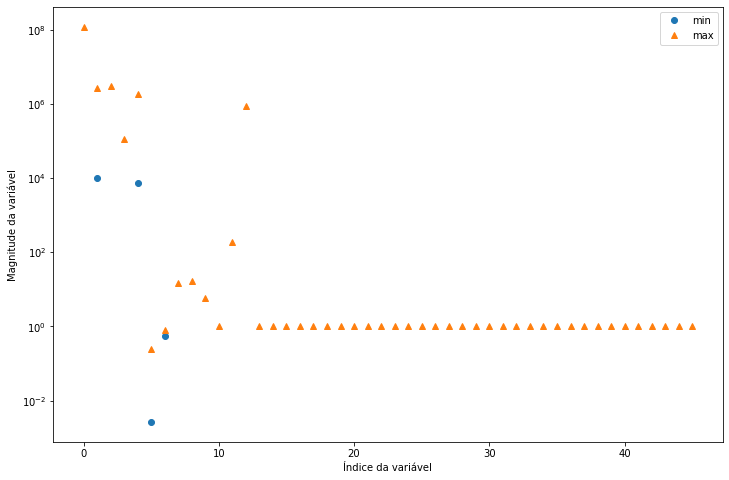

In [30]:
verifica_escala(variaveis_modelo,df)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[variaveis_modelo].values)
x=scaler.transform(df[variaveis_modelo].values)
df_scaled=pd.DataFrame(x,columns=variaveis_modelo)
df_scaled.head()
#df_original=df.copy()
df=df_scaled.copy()

In [ ]:
df.describe()

## Visualizando com PCA

In [ ]:
x=df.values
variaveis=list(df.columns)

In [ ]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=3)
# fit PCA model 
pca.fit(x)
# transform data onto the first two principal components
x_pca = pca.transform(x)
print("Original shape: {}".format(str(x.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))
df_pca=pd.DataFrame(x_pca,columns=["PC-1","PC-2","PC-3"])

In [ ]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
plt.scatter(x_pca[:, 0], x_pca[:, 1])
#plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")


In [ ]:
fig=px.scatter(df_pca, x='PC-1', y='PC-2', opacity=0.7)
fig.show()

In [ ]:
fig=px.scatter_3d(df_pca, x='PC-1', y='PC-2', z='PC-3',size_max=2, opacity=0.7, width=1000, height=900)
fig.show()

In [ ]:
df_pca_componentes=pd.DataFrame(pca.components_, columns=variaveis)
print("PCA component shape: {}".format(df_pca_componentes.shape))
df_pca_componentes
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")
#(correlação,annot=True, vmin=-1, vmax=1)

In [ ]:
def plot_pca_2d(x,y=True):
    plt.figure(figsize=(8, 8))
    if y.all():
        plt.scatter(x[:, 0], x[:, 1])
        plt.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            plt.scatter(x[row_ix, 0], x[row_ix, 1])
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    plt.legend(clusters, loc="best")
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

In [ ]:
def plot_pca_2d_px(df,cluster):
    df["cluster"]=cluster
    fig=px.scatter(df, x='PC-1', y='PC-2', color=cluster, opacity=0.7)
    fig.show()
    if clusters[0]==-1:
        quant=np.bincount(cluster+1)
    else:
        quant=np.bincount(cluster)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

In [ ]:
def plot_pca_3d(x,y=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y.all():
        ax.scatter(x[:, 0], x[:, 1],x[:,2])
        ax.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            ax.scatter(x[row_ix, 0], x[row_ix, 1],x[row_ix, 2], s=20)
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.set_zlabel("PC-3")
    ax.legend(clusters, loc='upper left')
    ax.view_init(35, -120)
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

In [ ]:
def plot_pca_3d_px(df,cluster):
    df["cluster"]=cluster
    fig=px.scatter_3d(df_pca, x='PC-1', y='PC-2', z='PC-3', color=cluster, opacity=0.7, width=1000, height=900)
    fig.show()
    if clusters[0]==-1:
        quant=np.bincount(cluster+1)
    else:
        quant=np.bincount(cluster)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))

## ajustando variáveis

In [ ]:
x=df.values

## K-mean


## Verificando o número de clusters via inércia

In [ ]:
kvalues=range(1,50)
kvalues
inercia=[]
for k in kvalues:
    modelo=KMeans(n_clusters=k, init='k-means++')
    modelo.fit(x)
    inercia.append(modelo.inertia_)
df_inercia=pd.DataFrame({"Inercia":inercia, "K":kvalues}) 
df_inercia.plot("K","Inercia", marker='o')

In [ ]:
# defining the kmeans function with initialization as k-means++
modelo = KMeans(n_clusters=6, init='k-means++')

# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(variaveis_modelo)


In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")
plot_pca_2d_px(df_pca,yhat)
plot_pca_3d_px(df_pca,yhat)

In [ ]:
df_kmeans=df_original.copy()
df_kmeans["cluster"]=yhat
df_kmeans.sample(5)

## Mean-shift


In [ ]:
from sklearn.cluster import MeanShift
modelo = MeanShift()
# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_mean_s=df_original.copy()
df_mean_s["cluster"]=yhat
df_mean_s.sample(5)

In [ ]:
## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
modelo = DBSCAN(eps=0.5, min_samples=3)

In [ ]:
modelo.fit(x)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_dbscan=df_original.copy()
df_dbscan["cluster"]=yhat
df_dbscan.sample(5)

## GMM

In [ ]:
from sklearn.mixture import GaussianMixture
modelo = GaussianMixture(n_components=6)
modelo.fit(x)
yhat = modelo.predict(x)

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_GMM=df_original.copy()
df_GMM["cluster"]=yhat
df_GMM.sample(5)

## Aglomerative H Cluster

In [ ]:
from sklearn.cluster import AgglomerativeClustering
modelo = AgglomerativeClustering(n_clusters=5)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
#df_HC=df_original.copy()
df_HC=df.copy()
df_HC["cluster"]=yhat
df_HC.sample(5)

## creating a distance matrix using linkage

In [ ]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Use the linkage() function
distance_matrix = linkage(x,method = 'ward', metric = 'euclidean') # method = 'single'/'complete'

# Assign cluster labels
#comic_con['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')
dendrogram(distance_matrix)

In [ ]:
#dendrogram(distance_matrix)
# Use fcluster to extract labels: labels
clusters = fcluster(distance_matrix, 1.6, criterion='distance' )
df_ch=df_original.copy()
df_ch["cluster"]=clusters
df_ch.head(5)

# Avaliação com ARI Adjusted Rand Score Index

In [ ]:
# adjusted rand score is 1, as the clustering is exactly the same
# df_kmeans, df_mean_s, df_dbscan, df_GMM, df_HC, df_ch

In [ ]:
from sklearn.metrics import adjusted_rand_score
target=df_HC
lista=[df_kmeans,df_mean_s,df_dbscan,df_GMM,df_HC,df_ch]

for df in lista:
    print("ARI: {:.2f}".format(adjusted_rand_score(target["cluster"].values, df["cluster"].values)))


## EDA com K-mean

In [ ]:
df=df_HC.copy()

## EDA Básico

In [ ]:
df.info()
df.describe().round(2)

In [ ]:
#df.fillna(0, inplace=True)
#df.info()

In [ ]:
df.describe(include=np.object)

In [ ]:
df.info()
unicos=df.nunique()
unicos

## Defindo variaveis categóricas numericas

In [ ]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            print(df[variavel].sort_values().unique())
    return lista

In [ ]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
variaveis_categoricas= df.select_dtypes(include="category").columns
df[variaveis_numericas].info()
df[variaveis_categoricas].info()

In [ ]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].info()

### Histogramas

In [ ]:
for variavel in variaveis_categoricas:
    df[variavel].value_counts().plot(kind="bar")
    plt.xlabel(variavel)
    plt.ylabel("Contagem")
    plt.title(variavel)
    plt.show()

### Boxplots - Identificando, verificando e tratando outliers


In [ ]:
for cat in variaveis_categoricas:
    for num in variaveis_numericas:
        sns.boxplot(x=cat, y=num, data=df)
        plt.xlabel(cat)
        plt.ylabel(num)
        plt.title(cat)
        plt.show()


In [ ]:
df.info()

In [ ]:
variaveis=list(variaveis_numericas)+list(variaveis_categoricas)
variaveis.remove("cluster")
preditores=variaveis
target=["cluster"]
variaveis=["cluster"]+variaveis
variaveis

In [ ]:

df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")

correlação=df[variaveis].corr()
correlação
plt.rc('figure', figsize=(12, 8))
sns.heatmap(correlação,annot=True, vmin=-1, vmax=1)

In [ ]:
sns.pairplot(df[variaveis], kind="scatter")

In [ ]:
sns.pairplot(df, y_vars=target, x_vars=preditores, hue=target[0])